# Simple Single Document Processing Pipeline Example

This notebook shows an explains a simple document processing pipeline to feed into a RAG use case.

The use case we'll be using is ingesting technical documentation to build a chat bot that can help users get started with the [Hamilton library](https://github.com/DAGWorks-Inc/hamilton).

Specifically, the purpose of this notebook is to help walkthrough and ground the following steps in code using the above use case:

![pipeline](pipeline-steps.png)

## Libraries Used
This code is meant to serve as a blueprint and enable you to change the internal implementations of functions easily for your use case.

It uses:
* [Hamilton](https://github.com/DAGWorks-Inc/hamilton), a library to orchestrate, visualize, and keep your code modular. We just have to [name our python functions](https://hamilton.dagworks.io/en/latests/concepts/node) appropriately to use it.
* [OpenAI](https://www.openai.com) to create embeddings.
* [LangChain](https://www.langchain.com) to help chunk text.

### Cell Magic explanation
You'll see `%%incr_cell_to_module` used below. This is a "cell magic". See this [blog post](https://blog.dagworks.io/p/using-ipython-jupyter-magic-commands) for an explanation of them. Here we use it to draw the pipeline as we're building it and then creating a module to group the code to execute the pipeline.

In [ ]:
# install the required packages to run this notebook
!pip install sf-hamilton[visualization] openai langchain-core requests pandas

In [20]:
# We use Hamilton's jupyter magic to help us visualize what we're building
%load_ext hamilton.plugins.jupyter_magic

The hamilton.plugins.jupyter_magic extension is already loaded. To reload it, use:
  %reload_ext hamilton.plugins.jupyter_magic


## Documents & Chunks
Below we establish some classes to help us describe what we want at the end of this process before we store things.

Specifically, what a `Chunk` is and what a `Document` is.

In [42]:
%%incr_cell_to_module doc_pipeline -i 1 --display

from typing import NamedTuple, Optional

class Chunk(NamedTuple):
    """Chunk of a Document - text & embedding."""
    index: int
    document_id: str
    text: str
    embedding: Optional[list[float]]
    metadata: Optional[dict[str, str]]
    
    def add_embedding(self, embedding: list[float]) -> "Chunk":
        """Required to update chunk with embeddings"""
        return Chunk(self.index, self.document_id, self.text, embedding, self.metadata)
    
    def add_metadata(self, metadata: dict[str, str]) -> "Chunk":
        """Required to update chunk with metadata"""
        return Chunk(self.index, self.document_id, self.text, self.embedding, metadata)

class Document(NamedTuple):
    """Document containing a full raw text, along with pointers to chunks."""
    id: str
    url: str
    raw_text: str
    chunks: Optional[list[Chunk]]
    
    def add_chunks(self, chunks: list[Chunk]) -> "Document":
        """Required to update the document when Chunks are created"""
        return Document(self.id, self.url, self.raw_text, chunks)

# 1. & 2. Load & Extract
Here we combine loading and extracting.

1. Load the document by pulling the HTML from the website.
2. Use a regular expression to extract the content from the page that we're interested in.


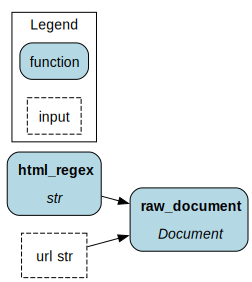

In [43]:
%%incr_cell_to_module doc_pipeline -i 2 --display
import requests 
import re
import uuid

def html_regex() -> str:
    """Context dependent logic for getting the right part of the HTML document."""
    return r'<article role="main" id="furo-main-content">(.*?)</article>'

def raw_document(url: str, html_regex: str) -> Document:
    """Loads and parses the HTML from a URL, returning the html text of interest.

    :param url: the url to pull.
    :param html_regex: the regext to use to get the contents out of.
    :return: sub-portion of the HTML
    """
    html_text = requests.get(url).text
    article = re.findall(html_regex, html_text, re.DOTALL)
    if not article:
        raise ValueError(f"No article found in {url}")
    raw_text = article[0].strip()
    return Document(str(uuid.uuid4()), url, raw_text, None)

In [44]:
# print(requests.get("https://hamilton.dagworks.io/en/latest/concepts/best-practices/code-organization/").text)
# we can test that this works by running the functions:
url = "https://hamilton.dagworks.io/en/latest/concepts/best-practices/code-organization/"
raw_document(url, html_regex())

Document(id='ff0780ba-db17-4fa1-b7fe-1f6445c6ab83', url='https://hamilton.dagworks.io/en/latest/concepts/best-practices/code-organization/', raw_text='<section id="code-organization">\n<h1>Code Organization<a class="headerlink" href="#code-organization" title="Link to this heading">¶</a></h1>\n<p>Hamilton will force you to organize your code! Here’s some tips.</p>\n<p>Hamilton forces you to put your code into modules that are distinct from where you run your code.</p>\n<p>You’ll soon find that a single python module does not make sense, and so you’ll organically start to (very likely) put\nlike functions with like functions, i.e. thus creating domain specific modules –&gt; <cite>use this to your development\nadvantage!</cite></p>\n<p>At Stitch Fix we:</p>\n<ol class="arabic simple">\n<li><p>Use modules to model team thinking, e.g. date_features.py.</p></li>\n<li><p>Use modules to helps isolate what you’re working on.</p></li>\n<li><p>Use modules to replace parts of your Hamilton datafl

# 3. Chunk the text into sections

Here we use part of LangChain's libraries to split the HTML into chunks that we will individually index and then search for when trying to answer questions. Assuming the documentation is well structured, it probably makes sense to "chunk" by headings, as that will logically split the text into (hopefully) self-contained sections (stripping HTML from the text in the process). But, these sections might still be quite large, so we want to further split this text. E.g. going from paragraphs to smaller sections.

We then attach the `chunks` to the `document` object.

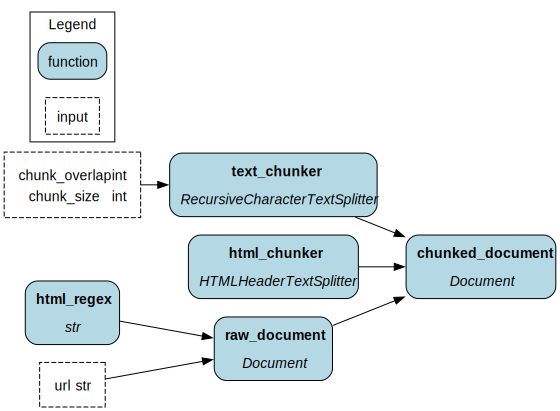

In [45]:
%%incr_cell_to_module doc_pipeline -i 3 --display

from langchain import text_splitter

def html_chunker() -> text_splitter.HTMLHeaderTextSplitter:
    """Object to help split HTML into chunks"""
    headers_to_split_on = [
        ("h1", "Header 1"),
        ("h2", "Header 2"),
        ("h3", "Header 3"),
    ]
    html_chunker = text_splitter.HTMLHeaderTextSplitter(
        headers_to_split_on=headers_to_split_on
    )
    return html_chunker

def text_chunker(
        chunk_size: int = 256, 
        chunk_overlap: int = 0) -> text_splitter.RecursiveCharacterTextSplitter:
    """Object to further split chunks"""
    return text_splitter.RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

def chunked_document(
    raw_document: Document,
    html_chunker: text_splitter.HTMLHeaderTextSplitter,
    text_chunker: text_splitter.RecursiveCharacterTextSplitter,
) -> Document:
    """This function takes in HTML, chunks the HTML, and then chunks it into text chunks."""
    header_splits = html_chunker.split_text(raw_document.raw_text)
    text_chunks = text_chunker.split_documents(header_splits)
    chunks = []
    for i, text_chunk in enumerate(text_chunks):
        chunks.append(
            Chunk(
                index=i,
                document_id=raw_document.id,
                text=text_chunk.page_content,
                embedding=None,
                metadata=text_chunk.metadata,
            )
        )
    # create new raw_document object
    raw_document = raw_document.add_chunks(chunks)
    return raw_document

In [46]:
# example what the HTML chunker is doing:
html_chunker().split_text("<h1>title</h1><p>some text</p><p>some more text</p><h2>subsection1</h2><p>section text<br/> more text</p>")

[Document(page_content='some text  \nsome more text', metadata={'Header 1': 'title'}),
 Document(page_content='section text more text', metadata={'Header 1': 'title', 'Header 2': 'subsection1'})]

In [47]:
# example what the text chunker is doing
text_chunker(5, 0).split_text("this is some text")

['this', 'is', 'some', 'text']

# 4. Embed the text chunks
For each text chunk, we send a request to OpenAI to get a vector embedding for that text.
This vector of numbers is a "semantic" representation in numbers of the context in the text sent.

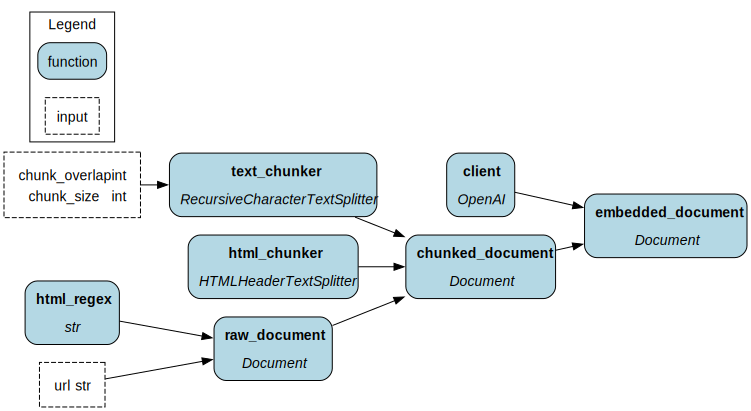

In [48]:
%%incr_cell_to_module doc_pipeline -i 4 --display
import openai

def client() -> openai.OpenAI:
    return openai.OpenAI()

def embedded_document(
    chunked_document: Document,
    client: openai.OpenAI,
) -> Document:
    """This function takes in a list of documents and outputs a list of documents with embeddings.
    """
    for idx, chunk in enumerate(chunked_document.chunks): 
        response = client.embeddings.create(input=chunk.text, 
                                            model="text-embedding-3-small")
        chunk = chunk.add_embedding(response.data[0].embedding)
        # mutate existing document 
        chunked_document.chunks[idx] = chunk
    return chunked_document

In [49]:
# example
client().embeddings.create(input="this is some text that will change into a vector", model="text-embedding-3-small").data[0].embedding

[-0.0285369660705328,
 0.062304042279720306,
 -0.01684781350195408,
 -0.015433112159371376,
 -0.049328796565532684,
 -0.0613894909620285,
 0.0034045730717480183,
 0.007237843703478575,
 0.01143907941877842,
 0.0047121006064116955,
 0.057016775012016296,
 0.011289035901427269,
 -0.04046905040740967,
 -0.009974363259971142,
 0.04890010133385658,
 0.004719245713204145,
 0.020205944776535034,
 -0.010210146196186543,
 -0.01826251484453678,
 0.0014370299177244306,
 -0.0010440571932122111,
 0.011581978760659695,
 0.0573311522603035,
 -0.0002672661212272942,
 0.005101501010358334,
 0.0016808516811579466,
 0.009188417345285416,
 0.026364900171756744,
 0.0593317411839962,
 -0.03583911433815956,
 -0.019105620682239532,
 -0.04095490649342537,
 -0.010867482982575893,
 -0.08722566068172455,
 0.01771949790418148,
 0.012567983008921146,
 0.020706091076135635,
 0.032123737037181854,
 0.0005912453634664416,
 -0.010953222401440144,
 -0.0053444295190274715,
 0.018919851630926132,
 0.038982897996902466,
 -

# 5. Store results
Where you store the result of the pipeline is heavily context and situation dependent.

Here for simplicity we put it into a pandas dataframe to easily display. One could then create a parquet, or CSV, from this dataframe, and then bulk ingest into a vector store or database. Or you could just directly write to them from inside this function.

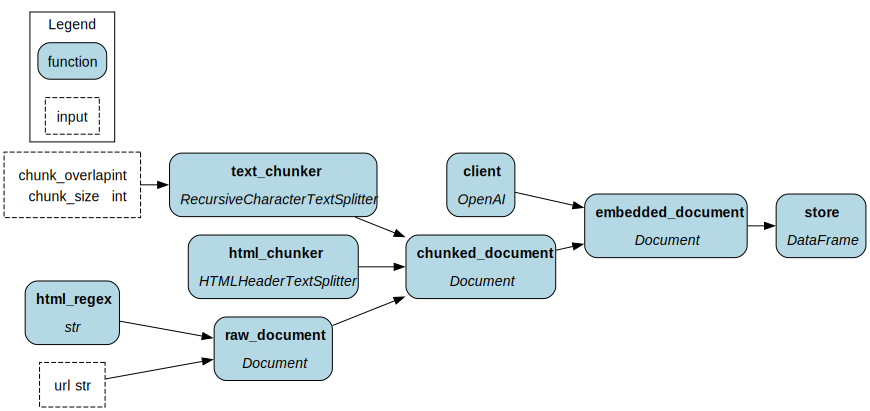

In [50]:
%%incr_cell_to_module doc_pipeline -i 5 --display
import pandas as pd

def store(
    embedded_document: Document,
) -> pd.DataFrame:
    """Function to index & store the document. Here we just put it into a pandas dataframe."""
    # make a pandas dataframe from the document
    # want a column for the document id, the chunk index, the text, the embedding, and the metadata
    rows = []
    for chunk in embedded_document.chunks:
        # need to 
        rows.append(
            {
                "document_id": embedded_document.id,
                "chunk_index": chunk.index,
                "url": embedded_document.url,
                "text": chunk.text,
                "embedding": chunk.embedding,
                "metadata": chunk.metadata,
            }
        )
    data_set = pd.DataFrame(rows)
    # we create an index using the document_id and chunk_index
    data_set.set_index(["document_id", "chunk_index"], inplace=True)
    return data_set

# Let's run the code!
Here we use Hamilton to run the pipeline from start to end, i.e. the picture you see above.

To do that we just need to:

1. Create a "driver"
2. Execute the driver providing inputs required. Note we could request any intermediate results.

In [51]:
from hamilton import driver

# create the driver
pipeline_driver = driver.Builder().with_modules(doc_pipeline).build()

# execute the pipeline for the given URL 
results = pipeline_driver.execute(["store"], inputs={"url": "https://hamilton.dagworks.io/en/latest/"})

# show the dataframe for this document
results["store"]

url  \
document_id                          chunk_index                                            
48ddfe27-0709-4b77-a155-d2ba24a67612 0            https://hamilton.dagworks.io/en/latest/   
                                     1            https://hamilton.dagworks.io/en/latest/   
                                     2            https://hamilton.dagworks.io/en/latest/   
                                     3            https://hamilton.dagworks.io/en/latest/   
                                     4            https://hamilton.dagworks.io/en/latest/   
                                     5            https://hamilton.dagworks.io/en/latest/   
                                     6            https://hamilton.dagworks.io/en/latest/   
                                     7            https://hamilton.dagworks.io/en/latest/   
                                     8            https://hamilton.dagworks.io/en/latest/   
                                     9            https://hamilton.dagworks.io/en/latest/   
                                     10           https://hamilton.dagworks.io/en/latest/   
                                     11           https://hamilton.dagworks.io/en/latest/   
                                     12           https://hamilton.dagworks.io/en/latest/   
                                     13           https://hamilton.dagworks.io/en/latest/   
                                     14           https://hamilton.dagworks.io/en/latest/   
                                     15           https://hamilton.dagworks.io/en/latest/   
                                     16           https://hamilton.dagworks.io/en/latest/   
                                     17           https://hamilton.dagworks.io/en/latest/   
                                     18           https://hamilton.dagworks.io/en/latest/   
                                     19           https://hamilton.dagworks.io/en/latest/   
                                     20           https://hamilton.dagworks.io/en/latest/   
                                     21           https://hamilton.dagworks.io/en/latest/   

                                                                                               text  \
document_id                          chunk_index                                                      
48ddfe27-0709-4b77-a155-d2ba24a67612 0            Hamilton is a general-purpose framework to wri...   
                                     1            Directed Acyclic Graph (DAG) that can be execu...   
                                     2                                         The ABC of Hamilton¶   
                                     3            Facilitate collaboration. By focusing on funct...   
                                     4            Visualizations can be generated directly from ...   
                                     5            Reduce development time. Hamilton dataflows ar...   
                                     6                                                Hamilton Hub.   
                                     7            Own your platform. Hamilton helps you integrat...   
                                     8            Scale your dataflow. Hamilton separates transf...   
                                     9                                   enterprise data workloads.   
                                     10           Here’s a quick overview of benefits that Hamil...   
                                     11           Can visualize lineage easily  \n✅  \n❌  \n❌  \...   
                                     12           Runs anywhere python runs  \n✅  \n❌  \n❌  \n❌ ...   
                                     13           The following diagram gives a simplified overv...   
                                     14           Functions & Module. Transformations are regula...   
                                     15           Driver & FunctionGraph. The Driver will automa...   

# How did the Hamilton driver know what our pipeline was?
By using cell magic, we have incrementally been creating the `doc_pipeline` python module.

Then when we did `driver.Builder().with_modules(doc_pipeline).build()` Hamilton took that python module and created the pipeline from it to execute. You can use the `%print_module` line magic to see the state of the python module at any time. You can then also use this as a means to export your notebook code.

In [52]:
%print_module doc_pipeline

from typing import NamedTuple, Optional

class Chunk(NamedTuple):
    """Chunk of a Document - text & embedding."""
    index: int
    document_id: str
    text: str
    embedding: Optional[list[float]]
    metadata: Optional[dict[str, str]]
    
    def add_embedding(self, embedding: list[float]) -> "Chunk":
        """Required to update chunk with embeddings"""
        return Chunk(self.index, self.document_id, self.text, embedding, self.metadata)
    
    def add_metadata(self, metadata: dict[str, str]) -> "Chunk":
        """Required to update chunk with metadata"""
        return Chunk(self.index, self.document_id, self.text, self.embedding, metadata)

class Document(NamedTuple):
    """Document containing a full raw text, along with pointers to chunks."""
    id: str
    url: str
    raw_text: str
    chunks: Optional[list[Chunk]]
    
    def add_chunks(self, chunks: list[Chunk]) -> "Document":
        """Required to update the document when Chunks are created"""
        return Document(self.id, self.url, self.raw_text, chunks)


import requests 
import re
import uuid

def html_regex() -> str:
    """Context dependent logic for getting the right part of the HTML document."""
    return r'<article role="main" id="furo-main-content">(.*?)</article>'

def raw_document(url: str, html_regex: str) -> Document:
    """Loads and parses the HTML from a URL, returning the html text of interest.

    :param url: the url to pull.
    :param html_regex: the regext to use to get the contents out of.
    :return: sub-portion of the HTML
    """
    html_text = requests.get(url).text
    article = re.findall(html_regex, html_text, re.DOTALL)
    if not article:
        raise ValueError(f"No article found in {url}")
    raw_text = article[0].strip()
    return Document(str(uuid.uuid4()), url, raw_text, None)



from langchain import text_splitter

def html_chunker() -> text_splitter.HTMLHeaderTextSplitter:
    """Object to help split HTML into chunks"""
    headers_to_split_on = [
        ("h1", "Header 1"),
        ("h2", "Header 2"),
        ("h3", "Header 3"),
    ]
    html_chunker = text_splitter.HTMLHeaderTextSplitter(
        headers_to_split_on=headers_to_split_on
    )
    return html_chunker

def text_chunker(
        chunk_size: int = 256, 
        chunk_overlap: int = 0) -> text_splitter.RecursiveCharacterTextSplitter:
    """Object to further split chunks"""
    return text_splitter.RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

def chunked_document(
    raw_document: Document,
    html_chunker: text_splitter.HTMLHeaderTextSplitter,
    text_chunker: text_splitter.RecursiveCharacterTextSplitter,
) -> Document:
    """This function takes in HTML, chunks the HTML, and then chunks it into text chunks."""
    header_splits = html_chunker.split_text(raw_document.raw_text)
    text_chunks = text_chunker.split_documents(header_splits)
    chunks = []
    for i, text_chunk in enumerate(text_chunks):
        chunks.append(
            Chunk(
                index=i,
                document_id=raw_document.id,
                text=text_chunk.page_content,
                embedding=None,
                metadata=text_chunk.metadata,
            )
        )
    # create new raw_document object
    raw_document = raw_document.add_chunks(chunks)
    return raw_document


import openai

def client() -> openai.OpenAI:
    return openai.OpenAI()

def embedded_document(
    chunked_document: Document,
    client: openai.OpenAI,
) -> Document:
    """This function takes in a list of documents and outputs a list of documents with embeddings.
    """
    for idx, chunk in enumerate(chunked_document.chunks): 
        response = client.embeddings.create(input=chunk.text, 
                                            model="text-embedding-3-small")
        chunk = chunk.add_embedding(response.data[0].embedding)
        # mutate existing document 
        chunked_document.chunks[idx] = chunk
    re

In [41]:
# use %reset_module NAME to reset the module.
# %reset_module doc_pipeline

Reset doc_pipeline
